<a href="https://colab.research.google.com/github/summermccune/Tokenization-Testing-for-Malware-Data/blob/main/Tokenization_Malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

### Imports

In [12]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [13]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/NSF REU/malware")
!ls

Mounted at /content/drive
4Families.csv	      4fams_small_train.csv  4fams_train.csv  Families	Tokenizers
4fams_small_test.csv  4fams_test.csv	     Embeddings       Plots	Tokens


In [59]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from datasets import load_dataset
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import Tokenizer, ByteLevelBPETokenizer, SentencePieceBPETokenizer
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from transformers import PreTrainedTokenizerFast
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score, precision_score, recall_score

###Functions

In [6]:
def saveToCsv(pathName, labels, data):
  '''
  Saves the data with its labels into a pkl file
  pathName = what pkl file will be named & where it's placed
  '''
  df = pd.DataFrame(list(zip(labels, data)), columns=['Label', 'Opcodes'])
  df.to_csv(pathName+'.csv')
  return df

In [7]:
def saveToPkl(pathName, labels, data):
  '''
  Saves the data with its labels into a pkl file
  pathName = what pkl file will be named & where it's placed
  '''
  df = pd.DataFrame(list(zip(labels, data)), columns=['Label', 'Opcodes'])
  df.to_pickle(pathName+'.pkl')
  return df

In [8]:
def readCsvSplit(csvFile):
  '''
  Reads in the given csv file as dataframe
  Splits the opcodes & labels of dataframe into series
  '''
  df = pd.read_csv(csvFile+'.csv')
  x = df['Opcodes']
  y = df['Label']
  return x, y

In [9]:
def readPklSplit(pklFile):
  '''
  Reads in the given csv file as dataframe
  Splits the opcodes & labels of dataframe into series
  '''
  df = pd.read_pickle(pklFile+'.pkl')
  x = df['Opcodes']
  y = df['Label']
  return x, y

### Shortcut to read in 4 families saved csv file ###

In [8]:
all_data = pd.read_csv("4Families.csv")

### Split training/testing data ###

In [9]:
x_train,x_test,y_train,y_test=train_test_split(all_data['Opcodes'], all_data['Label'], test_size=0.2, random_state=7, stratify=all_data['Label'])
print(y_test.value_counts())
print(y_train.value_counts())
print(x_train.head())
print(y_train.head())
print(x_test.head())
print(y_test.head())

Label
OnLineGames    200
Winwebsec      200
Vobfus         200
FakeRean       200
Name: count, dtype: int64
Label
OnLineGames    800
Vobfus         800
Winwebsec      800
FakeRean       800
Name: count, dtype: int64
1858    mov inc and and add in sub movsl in fnstsw inc...
1012    mov inc and and add in sub movsl in fnstsw inc...
2752    arpl aaa jae popf sub lret aaa jae int3 aaa ja...
2693    jg mov jb add mov jb lret mov jb or jb int3 mo...
3539    loope stos loop dec cmc pusha push mov sub pus...
Name: Opcodes, dtype: object
1858    OnLineGames
1012    OnLineGames
2752         Vobfus
2693         Vobfus
3539      Winwebsec
Name: Label, dtype: object
1524    mov inc and and add in sub movsl in fnstsw inc...
3558    push mov mov jmp in add repz mov mov mov add a...
2003    ljmp jb add mov jb push jb add movsb jb mov mo...
2203    std mov movsb jb jo jb jne jb jne jb jbe jb mo...
1173    mov inc and and add in sub movsl in fnstsw inc...
Name: Opcodes, dtype: object
1524    OnLineGames

### Saving train/test split to csv files

In [10]:
saveToCsv('4fams_train', y_train, x_train)
saveToCsv('4fams_test', y_test, x_test)

Label                                            Opcodes
0    OnLineGames  mov inc and and add in sub movsl in fnstsw inc...
1      Winwebsec  push mov mov jmp in add repz mov mov mov add a...
2         Vobfus  ljmp jb add mov jb push jb add movsb jb mov mo...
3         Vobfus  std mov movsb jb jo jb jne jb jne jb jbe jb mo...
4    OnLineGames  mov inc and and add in sub movsl in fnstsw inc...
..           ...                                                ...
795     FakeRean  adc adc test pop jl mov mov push push mov call...
796     FakeRean  push push push call mov push pop mov and push ...
797       Vobfus  std mov mov jb jne jb jbe jb daa mov jb outsl ...
798  OnLineGames  push push push push push call mov push push pu...
799     FakeRean  nop dec ljmp or popf sti in rol in das mov in ...

[800 rows x 2 columns]

###Shortcut to read in train/test split csv file

In [11]:
x_train, y_train = readCsvSplit('4fams_train')
x_test, y_test = readCsvSplit('4fams_test')

In [12]:
# SPLITTING: FOR THE SAKE OF TESTING OUT CODE: USING ONLY 400/4000 OF DATASET
x_train, x_rest, y_train, y_rest = train_test_split(x_train, y_train, test_size=0.9, random_state=7, stratify=y_train)
x_test, x_rest, y_test, y_rest = train_test_split(x_test, y_test, test_size=0.9, random_state=7, stratify=y_test)

saveToCsv('4fams_small_train', y_train, x_train)
saveToCsv('4fams_small_test', y_test, x_test)

Label                                            Opcodes
0        Vobfus  mov cmp xchg cmp or jae mov cmp add jae jb jae...
1        Vobfus  rcrb add add ja jb lret mov jb lret mov jb lre...
2      FakeRean  or ret int3 int3 int3 int3 int3 mov push mov m...
3        Vobfus  jg mov jb add mov jb xchg mov jb int3 mov jb a...
4     Winwebsec  push mov mov pop ret and sub lret cs hlt in sc...
..          ...                                                ...
75    Winwebsec  push mov sub push mov movl movl movl movl movl...
76       Vobfus  std mov mov jb cmp add jb mov mov jb loopne jb...
77    Winwebsec  shll iret int test sbb insl push pop nop mov l...
78  OnLineGames  mov inc and and add in sub movsl in fnstsw inc...
79     FakeRean  add add add call mov call ret int3 int3 int3 i...

[80 rows x 2 columns]

### Read in SMALL dataset

In [8]:
# FOR THE SAKE OF TESTING CODE: USE ONLY 400/4000 SAMPLES
x_train, y_train = readCsvSplit('4fams_small_train')
x_test, y_test = readCsvSplit('4fams_small_test')
print(y_train.value_counts())
print(y_test.value_counts())

Label
OnLineGames    80
Winwebsec      80
Vobfus         80
FakeRean       80
Name: count, dtype: int64
Label
Vobfus         20
FakeRean       20
Winwebsec      20
OnLineGames    20
Name: count, dtype: int64


## Tokenization Methods

####Single Words: Most common; M=31 (white space separation) ####

#####Defined Functions for topX & removeNonVocab

In [9]:
# Single Words: Most common; M=31 (white space separation)
def topX(max, series):
  '''
  Finds the top X (max) most commonly occuring tokens in given series
  '''
  ctr = Counter()
  for row in series:
    ctr.update(row.split())
  top_words = [count[0] for count in ctr.most_common(max)]
  return top_words

def removeNonVocab(vocab, series):
  '''
  Removes the words not in the given vocab list from the series
  '''
  rows = []
  vocab_str = '|'.join(vocab)
  pattern = '\\b((?!\\b( |' + vocab_str + ')\\b).)*\\b'
  for row in series:
    row = re.sub(pattern, '', row)
    rows.append(row.split())
  return rows # list of token lists

#####Generate Vocab Dictionary

In [10]:
top31_vocab = topX(31, x_train)
print(top31_vocab)

['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'dec', 'or', 'cmp', 'xor', 'lea', 'sub', 'and', 'adc', 'sbb', 'test', 'in', 'out', 'movl', 'jmp', 'int3', 'nop', 'ret', 'imul', 'je', 'lods', 'scas', 'stos', 'lret', 'jne']


In [ ]:
top31_vocab = ['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'or', 'dec', 'cmp', 'xor', 'sub', 'and', 'adc', 'lea', 'sbb', 'test', 'out', 'in', 'jmp', 'movl', 'int3', 'ret', 'je', 'imul', 'nop', 'stos', 'lods', 'scas', 'lret', 'jne']

#####Batch Remove NonVocab from Train

In [16]:
size = len(x_train)//4
p1 = removeNonVocab(top31_vocab, x_train[:size])

In [17]:
p2 = removeNonVocab(top31_vocab, x_train[size: size*2])

In [18]:
p3 = removeNonVocab(top31_vocab, x_train[size*2:size*3])

In [19]:
p4 = removeNonVocab(top31_vocab, x_train[size*3: size*4])

In [20]:
# join batched remove lists back together
remain_top31_train = [*p1, *p2, *p3, *p4]
top31_train = saveToPkl('Tokens/T31_train', y_train, remain_top31_train)
print(top31_train.shape)
top31_train.head()

(320, 2)


Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, in, sub, in, push, p...
1    Winwebsec  [add, push, add, push, add, push, add, add, ad...
2    Winwebsec  [or, nop, add, dec, dec, or, inc, sub, push, a...
3    Winwebsec  [xor, add, push, call, dec, dec, je, jmp, add,...
4       Vobfus  [mov, add, mov, xchg, mov, push, int3, mov, in...

#####Batch Remove NonVocab from Test

In [21]:
size = len(x_test)//2
p1 = removeNonVocab(top31_vocab, x_test[:size])

In [22]:
p2 = removeNonVocab(top31_vocab, x_test[size: size*2])

In [23]:
# join batched remove lists back together
remain_top31_test = [*p1, *p2]
top31_test = saveToPkl('Tokens/T31_test', y_test, remain_top31_test)
print(top31_test.shape)
top31_test.head()

(80, 2)


Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, or, mov, cmp, add, push,...
1     Vobfus  [add, add, lret, mov, lret, mov, lret, mov, or...
2   FakeRean  [or, ret, int3, int3, int3, int3, int3, mov, p...
3     Vobfus  [mov, add, mov, xchg, mov, int3, mov, add, mov...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, lret, in,...

#### Methods for BPE, WPC, UNI, BBPE, SPC

In [17]:
# General tokenizer & trainer setup
batch_size = 1000
files = {"train": "4fams_small_train.csv", "test": "4fams_small_test.csv"}
dataset = load_dataset("csv", data_files=files)
unk_token = "<UNK>"
spl_tokens = ["<UNK>", "<SEP>", "<MASK>", "<CLS>"]
v_size = 100 # Hyperparameter tuning

def batch_iterator(data):
  # Data refers to either "train" or "test"
  for i in range(0, len(dataset), batch_size):
      yield dataset[data]['Opcodes'][i : i + batch_size]

def prepare_tokenizer_trainer(alg):
    """
    Prepares the tokenizer and trainer with unknown & special tokens
    """
    if alg == 'BPE':
        tokenizer = Tokenizer(BPE(unk_token = unk_token))
        trainer = BpeTrainer(special_tokens = spl_tokens, vocab_size=v_size)
    elif alg == 'UNI':
        tokenizer = Tokenizer(Unigram())
        trainer = UnigramTrainer(unk_token= unk_token, special_tokens = spl_tokens, vocab_size=v_size)
    elif alg == 'WPC':
        tokenizer = Tokenizer(WordPiece(unk_token = unk_token))
        trainer = WordPieceTrainer(special_tokens = spl_tokens, vocab_size=v_size)

    tokenizer.pre_tokenizer = Whitespace()
    return tokenizer, trainer

def train_tokenizer(alg):
    """
    Trains the tokenizer
    """
    if (alg == 'BPE' or alg == 'UNI' or alg == 'WPC'):
      tokenizer, trainer = prepare_tokenizer_trainer(alg)
      tokenizer.train_from_iterator(batch_iterator('train'), trainer=trainer)
      return tokenizer
    elif alg == 'BBPE':
      tokenizer = ByteLevelBPETokenizer()
      tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=v_size)
    elif alg == 'SPC':
      tokenizer = SentencePieceBPETokenizer()
      tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=v_size)
    tokenizer.save("Tokenizers/"+alg+"-trained.json")
    return tokenizer

def encode(tokenizer):
  # FOR THE SAKE OF TESTING: ONLY USE 400/4000 OF DATASET
  train_encode = tokenizer.encode_batch(dataset['train']['Opcodes'])
  train_tokens = [encoding.tokens for encoding in train_encode]
  test_encode = tokenizer.encode_batch(dataset['test']['Opcodes'])
  test_tokens = [encoding.tokens for encoding in test_encode]
  return train_tokens, test_tokens

#### BPE: Character Byte Pair Encoding

In [23]:
# Train Character BPE tokenizer
BPE_tokenizer = train_tokenizer('BPE')
BPE_tokenizer.save("Tokenizers/BPE-trained.json")

In [ ]:
# Or load in previously trained tokenizer
BPE_tokenizer = Tokenizer.from_file("Tokenizers/BPE-trained.json")

In [24]:
BPE_train_tokens, BPE_test_tokens = encode(BPE_tokenizer)
print(BPE_train_tokens[0])
print(BPE_test_tokens[0])

['mov', 'inc', 'and', 'and', 'add', 'in', 'sub', 'mov', 'sl', 'in', 'f', 'n', 'st', 's', 'w', 'inc', 'l', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'lo', 'c', 'k', 'st', 'o', 's', 'st', 'o', 's', 'st', 'o', 's', 'adc', 'int', 'st', 'o', 's', 'add', 'and', 'and', 'jmp', 'and', 'test', 'call', 'jb', 'e', 'mov', 'inc', 'add', 'b', 'r', 'or', 'b', 'd', 'a', 's', 'pop', 'st', 'i', 'mov', 'push', 'mov', 'lea', 'push', 'and', 'sbb', 'xor', 'push', 'pop', 'out', 'f', 'u', 'c', 'o', 'm', 'f', 'b', 'st', 'p', 'j', 'e', 'mov', 'push', 'call', 'push', 'in', 'mov', 'mov', 'pop', 'in', 'inc', 'xchg', 'inc', 'inc', 'dec', 'push', 'ret', 'd', 'a', 's', 'dec', 'push', 'sub', 'd', 'i', 'v', 'l', 'push', 'adc', 'push', 'add', 'adc', 'cmp', 'jn', 'e', 'pop', 'test', 'sbb', 'loop', 'e', 'mov', 'cl', 'c', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'lea', 'v', 'e', 'ret', 'xor', 'push', 'cmp', 'mov', 'f', 'i', 'st', 'l', 'pop', 'cl', 'd', 'add', 'or', 'add', 'f', 's', 'l', 'ret', 'in', 'l', 'jmp', 

In [25]:
# Save tokenized data
BPE_train = saveToPkl('Tokens/BPE_train', dataset['train']['Label'], BPE_train_tokens)
BPE_test = saveToPkl('Tokens/BPE_test', dataset['test']['Label'], BPE_test_tokens)
print(BPE_train.head())
print(BPE_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, in, sub, mov, sl, in...
1    Winwebsec  [and, l, add, pop, a, push, add, pop, a, push,...
2    Winwebsec  [or, nop, add, dec, dec, or, adc, l, inc, sub,...
3    Winwebsec  [push, a, xor, add, push, call, add, l, dec, d...
4       Vobfus  [j, g, mov, jb, add, mov, jb, xchg, mov, jb, p...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, or, j, a, e, mov, cmp, a...
1     Vobfus  [r, c, r, b, add, add, j, a, jb, l, ret, mov, ...
2   FakeRean  [or, ret, int3, int3, int3, int3, int3, mov, p...
3     Vobfus  [j, g, mov, jb, add, mov, jb, xchg, mov, jb, i...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, l, ret, c...


#### WPC: WordPiece ####

In [32]:
# WordPiece
WPC_tokenizer = train_tokenizer('WPC')
WPC_tokenizer.save("Tokenizers/WPC-trained.json")

In [8]:
# Or load in previously trained tokenizer
WPC_tokenizer = Tokenizer.from_file("Tokenizers/WPC-trained.json")

In [12]:
WPC_train_tokens, WPC_test_tokens = encode(WPC_tokenizer)
print(WPC_train_tokens[0])
print(WPC_test_tokens[0])

['mov', 'inc', 'a', '##n', '##d', 'a', '##n', '##d', 'add', 'in', 's', '##u', '##b', 'mov', '##s', '##l', 'in', 'f', '##n', '##s', '##t', '##s', '##w', 'inc', '##l', 'push', 'push', 'push', 'pop', 'x', '##o', '##r', 'le', '##a', 'l', '##o', '##c', '##k', 's', '##t', '##o', '##s', 's', '##t', '##o', '##s', 's', '##t', '##o', '##s', 'ad', '##c', 'in', '##t', 's', '##t', '##o', '##s', 'add', 'a', '##n', '##d', 'a', '##n', '##d', 'j', '##mp', 'a', '##n', '##d', 't', '##e', '##s', '##t', 'call', 'j', '##b', '##e', 'mov', 'inc', 'add', '##b', 'r', '##o', '##r', '##b', 'd', '##a', '##s', 'pop', 's', '##t', '##i', 'mov', 'push', 'mov', 'le', '##a', 'push', 'a', '##n', '##d', 's', '##b', '##b', 'x', '##o', '##r', 'push', 'pop', 'o', '##u', '##t', 'f', '##u', '##c', '##o', '##m', 'f', '##b', '##s', '##t', '##p', 'j', '##e', 'mov', 'push', 'call', 'push', 'in', 'mov', 'mov', 'pop', 'in', 'inc', 'x', '##c', '##h', '##g', 'inc', 'inc', 'dec', 'push', 'r', '##e', '##t', 'd', '##a', '##s', 'dec', 'pu

In [13]:
# Save tokenized data
WPC_train = saveToPkl('Tokens/WPC_train', dataset['train']['Label'], WPC_train_tokens)
WPC_test = saveToPkl('Tokens/WPC_test', dataset['test']['Label'], WPC_test_tokens)
print(WPC_train.head())
print(WPC_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, a, ##n, ##d, a, ##n, ##d, add, in, ...
1    Winwebsec  [a, ##n, ##d, ##l, add, pop, ##a, push, add, p...
2    Winwebsec  [o, ##r, n, ##op, add, dec, dec, o, ##r, ad, #...
3    Winwebsec  [push, ##a, x, ##o, ##r, add, push, call, add,...
4       Vobfus  [j, ##g, mov, j, ##b, add, mov, j, ##b, x, ##c...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, x, ##c, ##h, ##g, cmp, o, ##r, j, #...
1     Vobfus  [r, ##c, ##r, ##b, add, add, j, ##a, j, ##b, l...
2   FakeRean  [o, ##r, r, ##e, ##t, in, ##t, ##3, in, ##t, #...
3     Vobfus  [j, ##g, mov, j, ##b, add, mov, j, ##b, x, ##c...
4  Winwebsec  [push, mov, mov, pop, r, ##e, ##t, a, ##n, ##d...


#### SPC: SentencePiece ####

In [28]:
# SentencePiece
SPC_tokenizer = train_tokenizer('SPC')
SPC_tokenizer.save("Tokenizers/SPC-trained.json")

In [10]:
# Or load in previously trained tokenizer
SPC_tokenizer = Tokenizer.from_file("Tokenizers/SPC-trained.json")

In [11]:
SPC_train_tokens, SPC_test_tokens = encode(SPC_tokenizer)
print(SPC_train_tokens[0])
print(SPC_test_tokens[0])

['▁mov', '▁inc', '▁and', '▁and', '▁add', '▁in', '▁sub', '▁mov', 's', 'l', '▁in', '▁f', 'n', 'st', 's', 'w', '▁inc', 'l', '▁push', '▁push', '▁push', '▁pop', '▁xor', '▁lea', '▁lo', 'c', 'k', '▁st', 'o', 's', '▁st', 'o', 's', '▁st', 'o', 's', '▁adc', '▁int', '▁st', 'o', 's', '▁add', '▁and', '▁and', '▁j', 'mp', '▁and', '▁test', '▁call', '▁j', 'b', 'e', '▁mov', '▁inc', '▁add', 'b', '▁r', 'or', 'b', '▁d', 'a', 's', '▁pop', '▁st', 'i', '▁mov', '▁push', '▁mov', '▁lea', '▁push', '▁and', '▁sbb', '▁xor', '▁push', '▁pop', '▁out', '▁f', 'u', 'c', 'o', 'm', '▁f', 'b', 'st', 'p', '▁j', 'e', '▁mov', '▁push', '▁call', '▁push', '▁in', '▁mov', '▁mov', '▁pop', '▁in', '▁inc', '▁xchg', '▁inc', '▁inc', '▁dec', '▁push', '▁r', 'et', '▁d', 'a', 's', '▁dec', '▁push', '▁sub', '▁d', 'i', 'v', 'l', '▁push', '▁adc', '▁push', '▁add', '▁adc', '▁cmp', '▁jn', 'e', '▁pop', '▁test', '▁sbb', '▁lo', 'op', 'e', '▁mov', '▁c', 'l', 'c', '▁pop', '▁pop', '▁pop', '▁push', '▁pop', '▁pop', '▁pop', '▁lea', 'v', 'e', '▁r', 'et', '▁xo

In [12]:
# Save tokenized data
SPC_train = saveToPkl('Tokens/SPC_train', dataset['train']['Label'], SPC_train_tokens)
SPC_test = saveToPkl('Tokens/SPC_test', dataset['test']['Label'], SPC_test_tokens)
print(SPC_train.head())
print(SPC_test.head())

         Label                                            Opcodes
0  OnLineGames  [▁mov, ▁inc, ▁and, ▁and, ▁add, ▁in, ▁sub, ▁mov...
1    Winwebsec  [▁and, l, ▁add, ▁pop, a, ▁push, ▁add, ▁pop, a,...
2    Winwebsec  [▁or, ▁, n, op, ▁add, ▁dec, ▁dec, ▁or, ▁adc, l...
3    Winwebsec  [▁push, a, ▁xor, ▁add, ▁push, ▁call, ▁add, l, ...
4       Vobfus  [▁j, g, ▁mov, ▁j, b, ▁add, ▁mov, ▁j, b, ▁xchg,...
       Label                                            Opcodes
0     Vobfus  [▁mov, ▁cmp, ▁xchg, ▁cmp, ▁or, ▁j, a, e, ▁mov,...
1     Vobfus  [▁r, c, r, b, ▁add, ▁add, ▁j, a, ▁j, b, ▁l, r,...
2   FakeRean  [▁or, ▁r, et, ▁int, 3, ▁int, 3, ▁int, 3, ▁int,...
3     Vobfus  [▁j, g, ▁mov, ▁j, b, ▁add, ▁mov, ▁j, b, ▁xchg,...
4  Winwebsec  [▁push, ▁mov, ▁mov, ▁pop, ▁r, et, ▁and, ▁sub, ...


#### UNI: Unigram Subword ####

In [18]:
# Unigram (subword)
UNI_tokenizer = train_tokenizer('UNI')
UNI_tokenizer.save("Tokenizers/UNI-trained.json")

In [ ]:
# Or load in previously trained tokenizer
UNI_tokenizer = Tokenizer.from_file("Tokenizers/UNI-trained.json")

In [19]:
UNI_train_tokens, UNI_test_tokens = encode(UNI_tokenizer)
print(UNI_train_tokens[0])
print(UNI_test_tokens[0])

['mov', 'inc', 'and', 'and', 'add', 'i', 'n', 'sub', 'movsl', 'i', 'n', 'fnst', 's', 'w', 'inc', 'l', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'l', 'o', 'ck', 's', 't', 'o', 's', 's', 't', 'o', 's', 's', 't', 'o', 's', 'a', 'd', 'c', 'int', 's', 't', 'o', 's', 'add', 'and', 'and', 'jmp', 'and', 'test', 'call', 'j', 'b', 'e', 'mov', 'inc', 'add', 'b', 'r', 'o', 'r', 'b', 'd', 'a', 's', 'pop', 's', 't', 'i', 'mov', 'push', 'mov', 'lea', 'push', 'and', 'sbb', 'xor', 'push', 'pop', 'out', 'f', 'u', 'c', 'o', 'm', 'f', 'b', 's', 't', 'p', 'j', 'e', 'mov', 'push', 'call', 'push', 'i', 'n', 'mov', 'mov', 'pop', 'i', 'n', 'inc', 'xchg', 'inc', 'inc', 'd', 'e', 'c', 'push', 'ret', 'd', 'a', 's', 'd', 'e', 'c', 'push', 'sub', 'd', 'i', 'v', 'l', 'push', 'a', 'd', 'c', 'push', 'add', 'a', 'd', 'c', 'cmp', 'j', 'n', 'e', 'pop', 'test', 'sbb', 'loope', 'mov', 'c', 'l', 'c', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'leave', 'ret', 'xor', 'push', 'cmp', 'mov', 'fist', 'l', 'pop', 'c', 'l

In [20]:
# Save tokenized data
UNI_train = saveToPkl('Tokens/UNI_train', dataset['train']['Label'], UNI_train_tokens)
UNI_test = saveToPkl('Tokens/UNI_test', dataset['test']['Label'], UNI_test_tokens)
print(UNI_train.head())
print(UNI_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, i, n, sub, movsl, i,...
1    Winwebsec  [and, l, add, pop, a, push, add, pop, a, push,...
2    Winwebsec  [o, r, n, o, p, add, d, e, c, d, e, c, o, r, a...
3    Winwebsec  [push, a, xor, add, push, call, add, l, d, e, ...
4       Vobfus  [j, g, mov, j, b, add, mov, j, b, xchg, mov, j...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, o, r, j, a, e, mov, cmp,...
1     Vobfus  [r, c, r, b, add, add, j, a, j, b, lret, mov, ...
2   FakeRean  [o, r, ret, int, 3, int, 3, int, 3, int, 3, in...
3     Vobfus  [j, g, mov, j, b, add, mov, j, b, xchg, mov, j...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, lret, c, ...


##Embedding Methods

### Word2Vec Embeddings ###

In [8]:
# Hyperparameters
v = 100 # vector size
w = 30 # window size

def w2v(train, test):
  model = Word2Vec(train, vector_size=v, window=w)
  train_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in train])
  test_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in test])
  return train_embeddings, test_embeddings


#### Single Words M=31

In [25]:
# Shortcut to read in tokens
T31_train_tokens, T31_y_train = readPklSplit('Tokens/T31_train')
T31_test_tokens, T31_y_test = readPklSplit('Tokens/T31_test')

In [26]:
# Single Word M=31
T31_train_w2v, T31_test_w2v = w2v(T31_train_tokens, T31_test_tokens)

In [27]:
# Save top31 embeddings
saveToPkl('Embeddings/W2v/T31_train_w2v', T31_y_train, T31_train_w2v)
saveToPkl('Embeddings/W2v/T31_test_w2v', T31_y_test, T31_test_w2v)

Label                                            Opcodes
0        Vobfus  [0.31082463, 0.16656592, 0.028407363, -0.54181...
1        Vobfus  [0.36657238, 0.14587696, 0.03810417, -0.414078...
2      FakeRean  [0.5085669, -0.07791692, 0.23427534, -0.301232...
3        Vobfus  [0.369045, 0.13802777, 0.046733998, -0.4543264...
4     Winwebsec  [0.27910164, -0.17563044, -0.04468694, 0.08609...
..          ...                                                ...
75    Winwebsec  [0.39372116, -0.08660598, 0.08423068, -0.44390...
76       Vobfus  [-0.005377842, -0.39217263, 0.5460347, -1.2255...
77    Winwebsec  [0.15215333, -0.045315046, -0.18435964, 0.1800...
78  OnLineGames  [0.0147366, -0.3235951, 0.16420855, -0.5872698...
79     FakeRean  [0.48814103, -0.09193846, 0.25916415, -0.33702...

[80 rows x 2 columns]

#### Character BPE

In [ ]:
# Shortcut to read in tokens
BPE_train_tokens, BPE_y_train = readPklSplit("Tokens/BPE_train")
BPE_test_tokens,  BPE_y_test = readPklSplit("Tokens/BPE_test")

In [12]:
# Character BPE
BPE_train_w2v, BPE_test_w2v = w2v(BPE_train_tokens, BPE_test_tokens)

NameError: name 'BPE_train_tokens' is not defined

In [29]:
# Save BPE embeddings
saveToPkl('./Embeddings/W2v/BPE_train_w2v', BPE_y_train, BPE_train_w2v)
saveToPkl('./Embeddings/W2v/BPE_test_w2v', BPE_y_test, BPE_test_w2v)

Label                                            Opcodes
0        Vobfus  [0.19384877, -0.13887163, 0.23485179, 0.037182...
1        Vobfus  [0.04090311, -0.23123617, 0.10503036, -0.09103...
2      FakeRean  [0.0338138, -0.15930967, -0.046119623, -0.0252...
3        Vobfus  [0.06531363, -0.22762355, 0.12306846, -0.07574...
4     Winwebsec  [0.08112681, -0.45545503, -0.36866447, -0.4441...
..          ...                                                ...
75    Winwebsec  [0.017986082, -0.7974654, -0.38634524, -0.5025...
76       Vobfus  [0.7511463, 0.9279787, 0.090373024, 1.6379477,...
77    Winwebsec  [0.050656844, -0.088684626, 0.22716565, -0.355...
78  OnLineGames  [0.31798032, 0.45840815, -0.05289732, 0.708383...
79     FakeRean  [0.020853039, -0.12908158, -0.08318295, 0.0402...

[80 rows x 2 columns]

#### WordPiece

In [9]:
# Shortcut to read in tokens
WPC_train_tokens, WPC_y_train = readPklSplit("Tokens/WPC_train")
WPC_test_tokens,  WPC_y_test = readPklSplit("Tokens/WPC_test")

In [13]:
# WordPiece
WPC_train_w2v, WPC_test_w2v = w2v(WPC_train_tokens, WPC_test_tokens)

In [14]:
# Save WordPiece embeddings
saveToPkl('./Embeddings/W2v/WPC_train_w2v', WPC_y_train, WPC_train_w2v)
saveToPkl('./Embeddings/W2v/WPC_test_w2v', WPC_y_test, WPC_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.1540402, 0.15571289, -0.44724944, -0.81924...
1        Vobfus  [-0.16953048, 0.35688353, -0.40208074, -0.9413...
2      FakeRean  [-0.3233312, 0.3129941, -0.07510721, -0.630887...
3        Vobfus  [-0.16538283, 0.32644066, -0.39600307, -0.8866...
4     Winwebsec  [-0.0053400067, 0.22685331, 0.17713654, -0.479...
..          ...                                                ...
75    Winwebsec  [-0.5315097, 0.584941, 0.30193782, -0.5994048,...
76       Vobfus  [-0.5018635, -0.4904157, 0.03029053, -0.616690...
77    Winwebsec  [-0.28793696, 0.02001566, -0.23961309, -0.5029...
78  OnLineGames  [-0.18904018, -0.14267743, 0.011463068, -0.419...
79     FakeRean  [-0.3428595, 0.28670993, -0.08827966, -0.65260...

[80 rows x 2 columns]

####SentencePiece

In [24]:
# Shortcut to read in tokens
SPC_train_tokens, SPC_y_train = readPklSplit("Tokens/SPC_train")
SPC_test_tokens,  SPC_y_test = readPklSplit("Tokens/SPC_test")

In [25]:
# SentencePiece
SPC_train_w2v, SPC_test_w2v = w2v(SPC_train_tokens, SPC_test_tokens)

In [26]:
# Save SentencePiece embeddings
saveToPkl('./Embeddings/W2v/SPC_train_w2v', SPC_y_train, SPC_train_w2v)
saveToPkl('./Embeddings/W2v/SPC_test_w2v', SPC_y_test, SPC_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.2083771, -0.19124888, 0.339916, -0.3260013...
1        Vobfus  [-0.12041399, -0.28546846, 0.55913615, -0.6030...
2      FakeRean  [-0.06480191, -0.2612142, 0.3677679, -0.405357...
3        Vobfus  [-0.14982717, -0.24604246, 0.45610076, -0.5293...
4     Winwebsec  [0.39961794, -0.1338859, 0.22603856, 0.0238467...
..          ...                                                ...
75    Winwebsec  [-0.089973524, -0.39310372, 0.9888692, -0.7887...
76       Vobfus  [-0.13233256, 0.106318645, -0.634718, 0.107228...
77    Winwebsec  [-0.22535029, -0.003619174, 0.37371024, -0.033...
78  OnLineGames  [0.21541783, 0.092431195, -0.20003465, 0.22956...
79     FakeRean  [-0.07626237, -0.23660831, 0.34208572, -0.3913...

[80 rows x 2 columns]

####Unigram

In [21]:
# Shortcut to read in tokens
UNI_train_tokens, UNI_y_train = readPklSplit("Tokens/UNI_train")
UNI_test_tokens,  UNI_y_test = readPklSplit("Tokens/UNI_test")

In [22]:
# Unigram Subword
UNI_train_w2v, UNI_test_w2v = w2v(UNI_train_tokens, UNI_test_tokens)

In [23]:
# Save Unigram Subword embeddings
saveToPkl('./Embeddings/W2v/UNI_train_w2v', UNI_y_train, UNI_train_w2v)
saveToPkl('./Embeddings/W2v/UNI_test_w2v', UNI_y_test, UNI_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.6616016, -0.17704597, -0.36743197, 0.59319...
1        Vobfus  [-0.590972, -0.23107593, -0.58176017, 0.764632...
2      FakeRean  [-0.44426015, 0.24354666, -0.41671935, 0.78825...
3        Vobfus  [-0.54443, -0.18773034, -0.5486641, 0.7651026,...
4     Winwebsec  [0.37256694, -0.09654294, -0.12058604, 0.61477...
..          ...                                                ...
75    Winwebsec  [-0.4415757, -0.15916534, -0.6326775, 1.142163...
76       Vobfus  [-1.0041813, 0.68850756, 0.49880323, 0.4237026...
77    Winwebsec  [-0.28853396, 0.13133976, -0.13964999, 0.28848...
78  OnLineGames  [-0.2362623, 0.35394228, 0.3859618, 0.4801382,...
79     FakeRean  [-0.46806073, 0.2775875, -0.40858692, 0.770066...

[80 rows x 2 columns]

##Classification Models

In [32]:
names = ['FakeRean', 'OnLineGames', 'Vobfus', 'Winwebsec']

def measures(y_pred, y_test, title):
  # Confusion matrix, F1, Precision, Recall, Accuracy (Test & Train)
  f1 = f1_score(y_test, y_pred, average="macro")
  precision = precision_score(y_test, y_pred, average="macro")
  recall = recall_score(y_test, y_pred, average="macro")
  test_acc = accuracy_score(y_test, y_pred)

  print(f'F1: {round(f1*100,2)}%')
  print(f'Precision: {round(precision*100,2)}%')
  print(f'Recall: {round(recall*100,2)}%')
  print(f'Accuracy: {round(test_acc*100,2)}%')

  cm = confusion_matrix(y_test, y_pred, labels=names)
  print(cm)

  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.savefig('Plots/'+title+'.png', bbox_inches='tight')
  plt.show()


def train_acc(clf, x_train, y_train):
  if type(x_train) == pd.Series :
    x_train = x_train.to_list()
    y_train = y_train.to_list()
  y_pred = clf.predict(x_train)
  train_acc = accuracy_score(y_train, y_pred)
  print(f'train_accuracy: {round(train_acc*100,2)}%')

In [16]:
# Shorcut to read in embeddings
T31_train_w2v, T31_y_train = readPklSplit("Embeddings/W2v/T31_train_w2v")
T31_test_w2v, T31_y_test = readPklSplit("Embeddings/W2v/T31_test_w2v")

BPE_train_w2v, BPE_y_train = readPklSplit("Embeddings/W2v/BPE_train_w2v")
BPE_test_w2v, BPE_y_test = readPklSplit("Embeddings/W2v/BPE_test_w2v")

WPC_train_w2v, WPC_y_train = readPklSplit("Embeddings/W2v/WPC_train_w2v")
WPC_test_w2v, WPC_y_test = readPklSplit("Embeddings/W2v/WPC_test_w2v")

SPC_train_w2v, SPC_y_train = readPklSplit("Embeddings/W2v/SPC_train_w2v")
SPC_test_w2v, SPC_y_test = readPklSplit("Embeddings/W2v/SPC_test_w2v")

UNI_train_w2v, UNI_y_train = readPklSplit("Embeddings/W2v/UNI_train_w2v")
UNI_test_w2v, UNI_y_test = readPklSplit("Embeddings/W2v/UNI_test_w2v")

### Random Forest ###

In [3]:
def fitRF(train, test, y_train):
  clf = RandomForestClassifier(n_estimators=1400, max_depth=40, bootstrap=False)
  if type(train) == pd.Series :
    train = train.to_list()
    y_train = y_train.to_list()
    test = test.to_list()
  clf.fit(train, y_train)
  y_pred = clf.predict(test)
  return clf, y_pred

#### Single Words M=31

train_accuracy: 100.0%
F1: 87.55%
Precision: 88.24%
Recall: 87.5%
Accuracy: 87.5%
[[15  0  0  5]
 [ 0 18  1  1]
 [ 1  0 19  0]
 [ 1  1  0 18]]


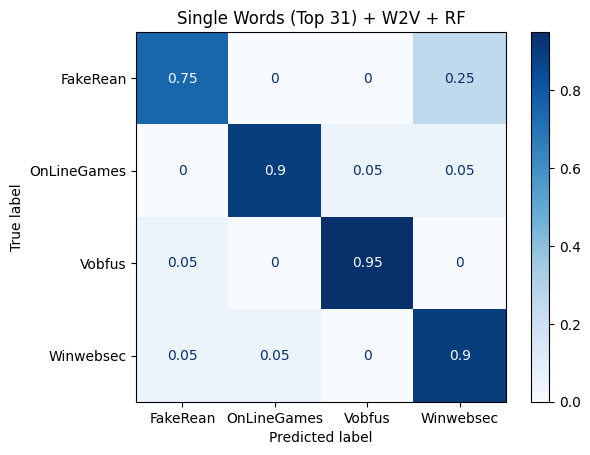

In [31]:
# Single Word: M=31
T31_rf, T31_rf_pred = fitRF(T31_train_w2v, T31_test_w2v, T31_y_train)
train_acc(T31_rf, T31_train_w2v, T31_y_train)
measures(T31_rf_pred, T31_y_test, 'Single Words (Top 31) + W2V + RF')

#### Character BPE

train_accuracy: 100.0%
F1: 87.64%
Precision: 88.67%
Recall: 87.5%
Accuracy: 87.5%
[[15  0  0  5]
 [ 1 17  0  2]
 [ 0  0 20  0]
 [ 1  1  0 18]]


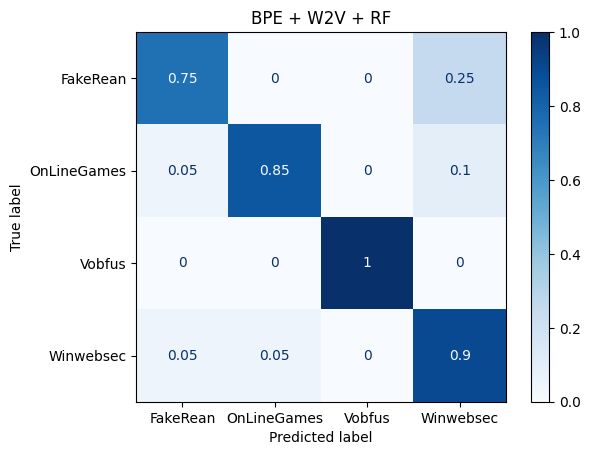

In [27]:
# BPE
BPE_rf, BPE_rf_pred = fitRF(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
train_acc(BPE_rf, BPE_train_w2v, BPE_y_train)
measures(BPE_rf_pred, BPE_y_test, 'BPE + W2V + RF')

####WordPiece

train_accuracy: 100.0%
F1: 91.33%
Precision: 92.01%
Recall: 91.25%
Accuracy: 91.25%
[[16  0  0  4]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 1  0  0 19]]


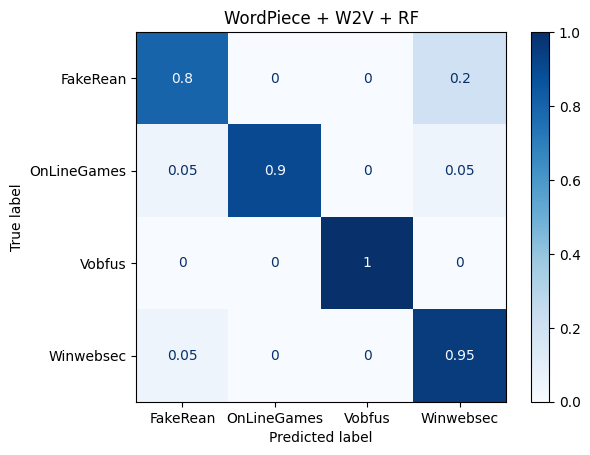

In [28]:
# WPC
WPC_rf, WPC_rf_pred = fitRF(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
train_acc(WPC_rf, WPC_train_w2v, WPC_y_train)
measures(WPC_rf_pred, WPC_y_test, 'WordPiece + W2V + RF')

####SentencePiece

train_accuracy: 100.0%
F1: 91.42%
Precision: 92.53%
Recall: 91.25%
Accuracy: 91.25%
[[16  0  0  4]
 [ 0 18  0  2]
 [ 0  0 20  0]
 [ 1  0  0 19]]


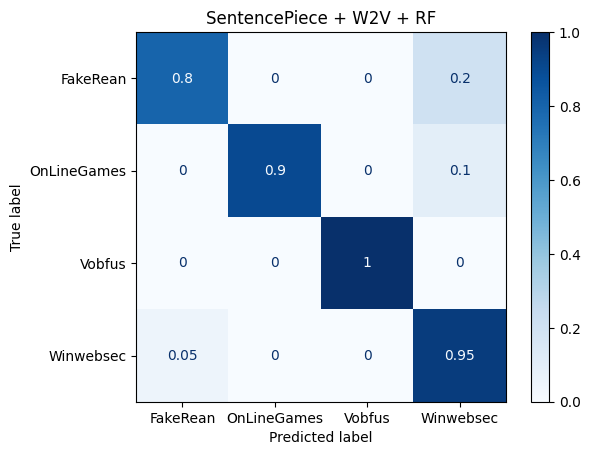

In [33]:
# SPC
SPC_rf, SPC_rf_pred = fitRF(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
train_acc(SPC_rf, SPC_train_w2v, SPC_y_train)
measures(SPC_rf_pred, SPC_y_test, 'SentencePiece + W2V + RF')

####Unigram Subword

train_accuracy: 100.0%
F1: 83.68%
Precision: 83.67%
Recall: 83.75%
Accuracy: 83.75%
[[16  2  0  2]
 [ 1 16  1  2]
 [ 1  0 19  0]
 [ 1  2  1 16]]


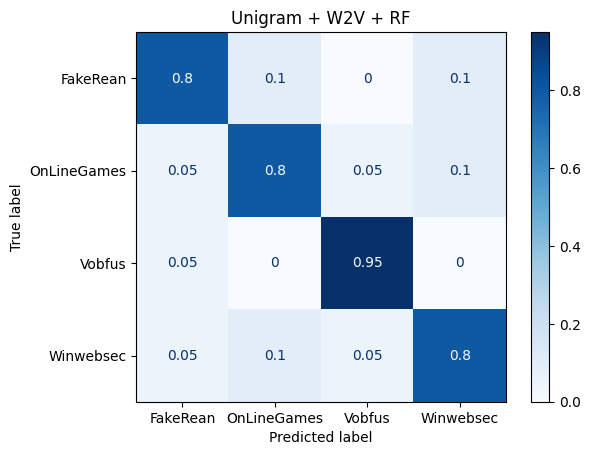

In [88]:
# UNI
UNI_rf, UNI_rf_pred = fitRF(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
train_acc(UNI_rf, UNI_train_w2v, UNI_y_train)
measures(UNI_rf_pred, UNI_y_test, 'Unigram + W2V + RF')

### KNN: K-Nearest Neighbors

In [9]:
def fitKNN(train, test, y_train):
  clf = KNeighborsClassifier(n_neighbors=70)
  if type(train) == pd.Series:
    train = train.to_list()
    y_train = y_train.to_list()
    test = test.to_list()
  clf.fit(train, y_train)
  y_pred = clf.predict(test)
  return clf, y_pred

####Single Words M=31

F1: 64.26%
Precision: 67.45%
Recall: 63.75%
Accuracy: 63.75%
[[14  3  0  3]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 3  1  1 15]]


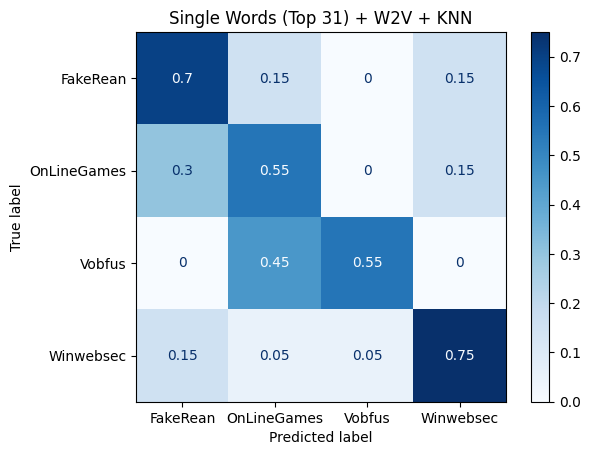

In [55]:
# Single Words M=31
T31_knn, T31_knn_pred = fitKNN(T31_train_w2v, T31_test_w2v, T31_y_train)
measures(T31_knn_pred, T31_y_test, 'Single Words (Top 31) + W2V + KNN')

#### BPE: Byte Pair Encoding

F1: 54.62%
Precision: 58.91%
Recall: 53.75%
Accuracy: 53.75%
[[12  5  0  3]
 [ 7 11  0  2]
 [ 0  9 11  0]
 [ 8  1  2  9]]


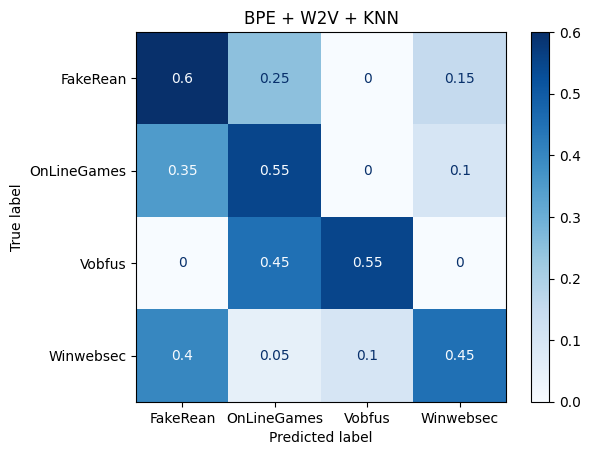

In [56]:
# BPE
BPE_knn, BPE_knn_pred = fitKNN(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
measures(BPE_knn_pred, BPE_y_test, 'BPE + W2V + KNN')

####WordPiece

F1: 57.32%
Precision: 61.24%
Recall: 56.25%
Accuracy: 56.25%
[[11  5  0  4]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 6  1  1 12]]


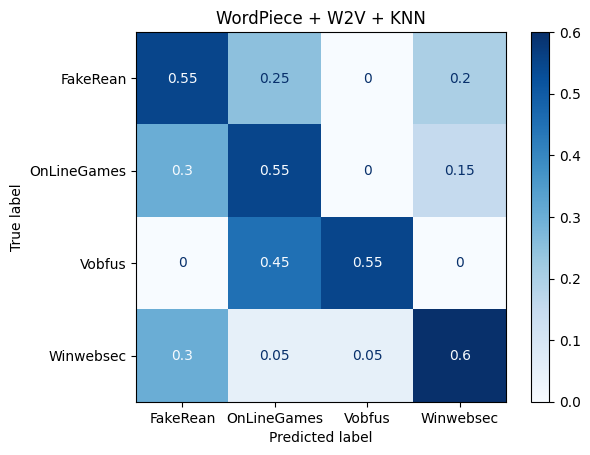

In [57]:
# WPC
WPC_knn, WPC_knn_pred = fitKNN(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
measures(WPC_knn_pred, WPC_y_test, 'WordPiece + W2V + KNN')

####SentencePiece

F1: 59.91%
Precision: 64.7%
Recall: 58.75%
Accuracy: 58.75%
[[13  4  0  3]
 [ 8 11  0  1]
 [ 0  9 11  0]
 [ 6  1  1 12]]


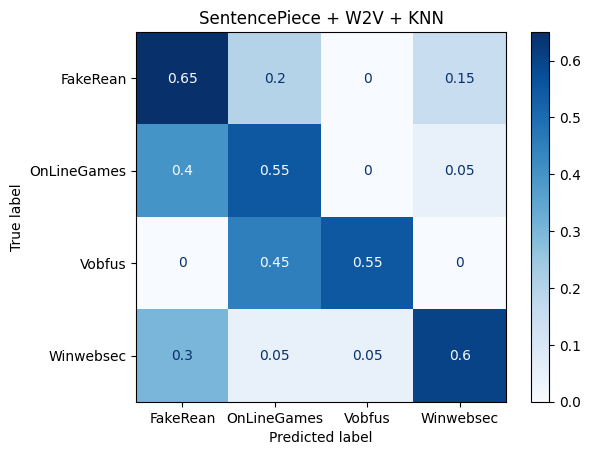

In [58]:
# SPC
SPC_knn, SPC_knn_pred = fitKNN(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
measures(SPC_knn_pred, SPC_y_test, 'SentencePiece + W2V + KNN')

####Unigram Subword

F1: 55.74%
Precision: 58.86%
Recall: 55.0%
Accuracy: 55.0%
[[12  4  0  4]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 7  1  2 10]]


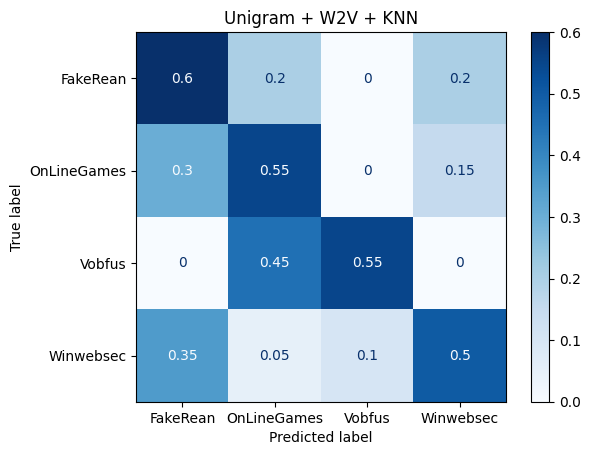

In [59]:
# UNI
UNI_knn, UNI_knn_pred = fitKNN(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
measures(UNI_knn_pred, UNI_y_test, 'Unigram + W2V + KNN')

###SVM: Support Vector Machine###

In [14]:
# REMEMBER TO CHANGE W2V embedding window=10, vector_size=31
def fitSVM(train, test, y_train, svm_type):
    clf = SVC(kernel=svm_type)
    if type(train) == pd.Series:
      train = train.to_list()
      y_train = y_train.to_list()
      test = test.to_list()
    clf.fit(train, y_train)
    y_pred = clf.predict(test)
    return clf, y_pred

####RBF SVM

##### Single Words M=31

F1: 78.37%
Precision: 80.05%
Recall: 78.75%
Accuracy: 78.75%
[[16  0  0  4]
 [ 6 11  1  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


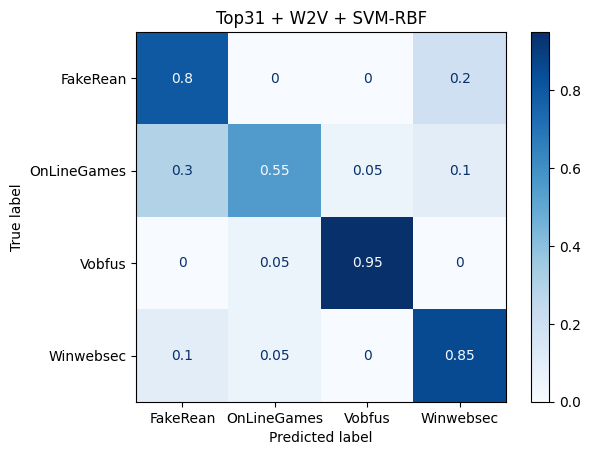

In [60]:
# Single Words M=31; RBF SVM
T31_svm_rbf, T31_svm_pred_rbf = fitSVM(T31_train_w2v, T31_test_w2v, T31_y_train, 'rbf')
measures(T31_svm_pred_rbf, T31_y_test, 'Top31 + W2V + SVM-RBF')

#####BPE

F1: 78.77%
Precision: 80.44%
Recall: 78.75%
Accuracy: 78.75%
[[15  0  0  5]
 [ 6 12  0  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


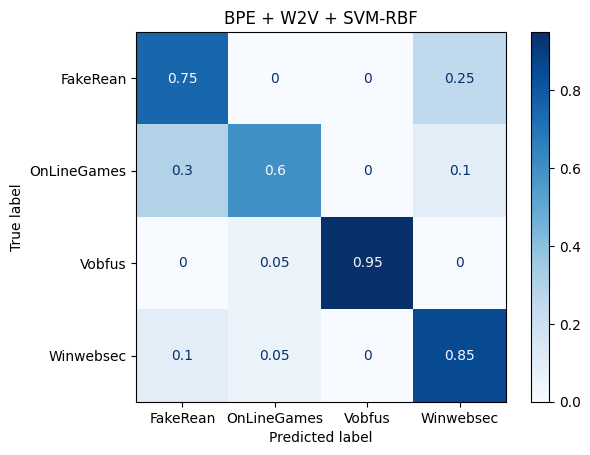

In [61]:
# BPE
BPE_svm_rbf, BPE_svm_pred_rbf = fitSVM(BPE_train_w2v, BPE_test_w2v, BPE_y_train, 'rbf')
measures(BPE_svm_pred_rbf, BPE_y_test, 'BPE + W2V + SVM-RBF')

#####WordPiece

F1: 79.66%
Precision: 81.57%
Recall: 80.0%
Accuracy: 80.0%
[[17  0  0  3]
 [ 5 11  0  4]
 [ 0  1 19  0]
 [ 2  1  0 17]]


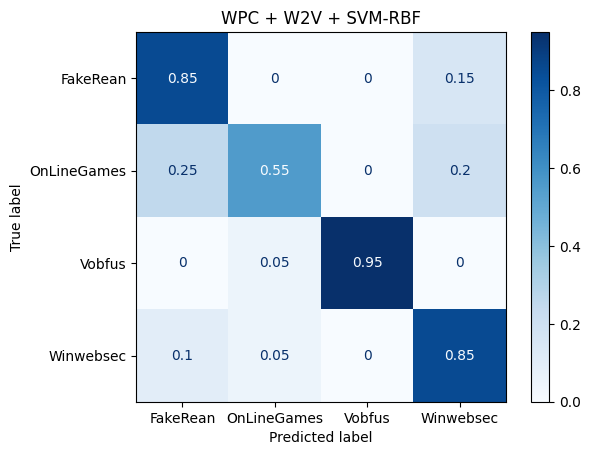

In [62]:
# WPC
WPC_svm_rbf, WPC_svm_pred_rbf = fitSVM(WPC_train_w2v, WPC_test_w2v, WPC_y_train, 'rbf')
measures(WPC_svm_pred_rbf, WPC_y_test, 'WPC + W2V + SVM-RBF')

#####SentencePiece

F1: 83.63%
Precision: 84.71%
Recall: 83.75%
Accuracy: 83.75%
[[17  0  0  3]
 [ 5 13  0  2]
 [ 0  1 19  0]
 [ 1  1  0 18]]


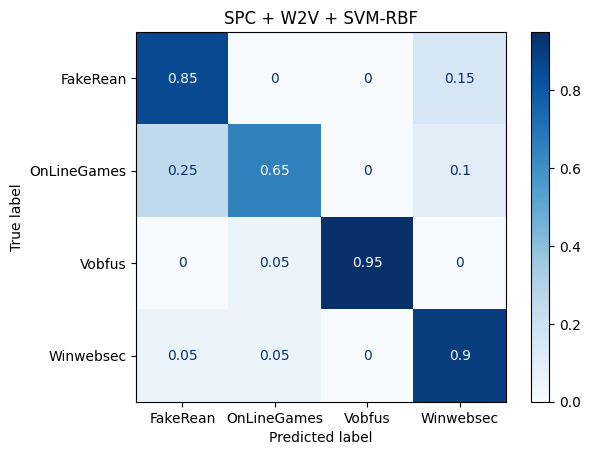

In [63]:
# SPC
SPC_svm_rbf, SPC_svm_pred_rbf = fitSVM(SPC_train_w2v, SPC_test_w2v, SPC_y_train, 'rbf')
measures(SPC_svm_pred_rbf, SPC_y_test, 'SPC + W2V + SVM-RBF')

#####Unigram Subword

F1: 82.43%
Precision: 83.6%
Recall: 82.5%
Accuracy: 82.5%
[[16  0  0  4]
 [ 5 13  0  2]
 [ 0  1 19  0]
 [ 1  1  0 18]]


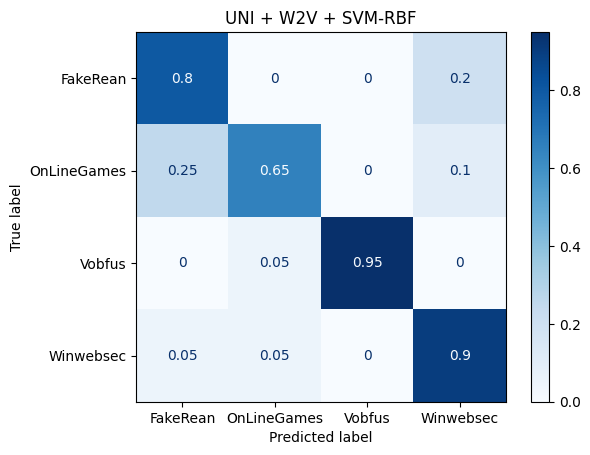

In [64]:
# UNI
UNI_svm_rbf, UNI_svm_pred_rbf = fitSVM(UNI_train_w2v, UNI_test_w2v, UNI_y_train, 'rbf')
measures(UNI_svm_pred_rbf, UNI_y_test, 'UNI + W2V + SVM-RBF')

####Linear SVM

#####Single Words M=31

F1: 92.38%
Precision: 92.68%
Recall: 92.5%
Accuracy: 92.5%
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  0 20  0]
 [ 2  1  1 16]]


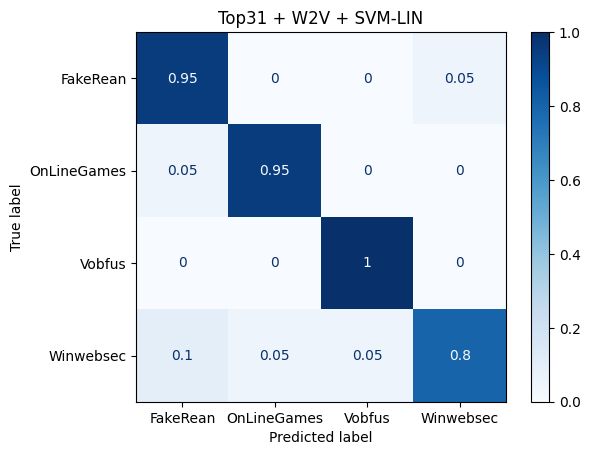

In [65]:
# Single Words M=31; RBF SVM
T31_svm_lin, T31_svm_pred_lin = fitSVM(T31_train_w2v, T31_test_w2v, T31_y_train, 'linear')
measures(T31_svm_pred_lin, T31_y_test, 'Top31 + W2V + SVM-LIN')

##### BPE

F1: 87.55%
Precision: 87.74%
Recall: 87.5%
Accuracy: 87.5%
[[17  1  0  2]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 3  1  0 16]]


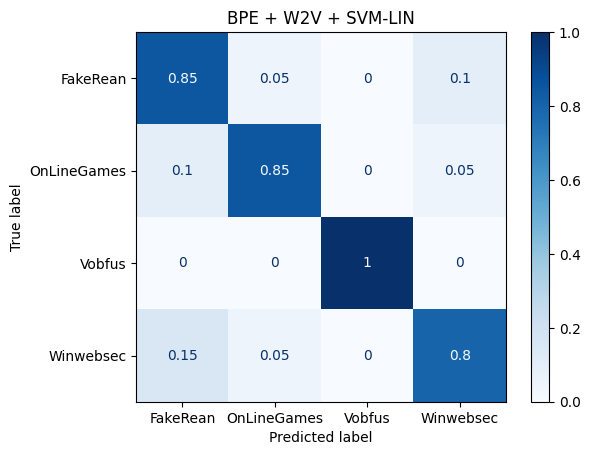

In [66]:
# BPE
BPE_svm_lin, BPE_svm_pred_lin = fitSVM(BPE_train_w2v, BPE_test_w2v, BPE_y_train, 'linear')
measures(BPE_svm_pred_lin, BPE_y_test, 'BPE + W2V + SVM-LIN')

#####WordPiece

F1: 83.75%
Precision: 84.25%
Recall: 83.75%
Accuracy: 83.75%
[[18  0  0  2]
 [ 2 16  0  2]
 [ 0  1 19  0]
 [ 4  2  0 14]]


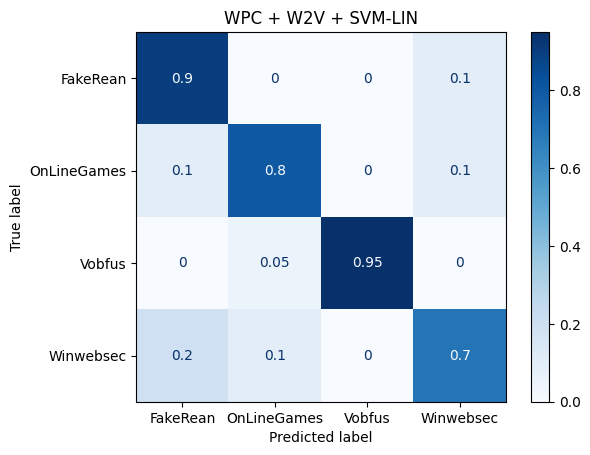

In [67]:
# WPC
WPC_svm_lin, WPC_svm_pred_lin = fitSVM(WPC_train_w2v, WPC_test_w2v, WPC_y_train, 'linear')
measures(WPC_svm_pred_lin, WPC_y_test, 'WPC + W2V + SVM-LIN')

#####SentencePiece

F1: 86.37%
Precision: 86.83%
Recall: 86.25%
Accuracy: 86.25%
[[17  0  0  3]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 4  1  0 15]]


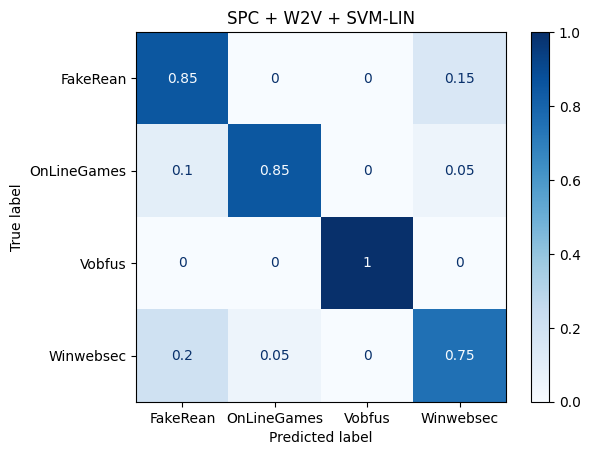

In [68]:
# SPC
SPC_svm_lin, SPC_svm_pred_lin = fitSVM(SPC_train_w2v, SPC_test_w2v, SPC_y_train, 'linear')
measures(SPC_svm_pred_lin, SPC_y_test, 'SPC + W2V + SVM-LIN')

#####Unigram Subword

F1: 90.06%
Precision: 90.17%
Recall: 90.0%
Accuracy: 90.0%
[[17  0  0  3]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 2  1  0 17]]


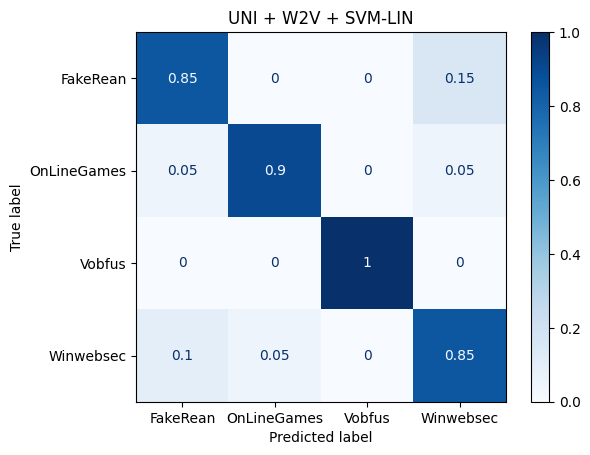

In [69]:
# UNI
UNI_svm_lin, UNI_svm_pred_lin = fitSVM(UNI_train_w2v, UNI_test_w2v, UNI_y_train, 'linear')
measures(UNI_svm_pred_lin, UNI_y_test, 'UNI + W2V + SVM-LIN')

### CNN

In [60]:
# CNN: Data 80/10/10 train/val/test split
# input layer dim=200; hidden=500, output=7
# train 50 epochs, MSE loss, Adam optimizer, dropout 0.5
# learning rate = 0.001
# beta1 = 0.9; beta2 = 0.999
# N (vector size)=100, Window=5 for w2v

model = models.Sequential([
    layers.Input(shape=(200, (1))),
    layers.Conv1D(500, (1), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])
# compile model
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 200, 500)          1000      
                                                                 
 dropout_14 (Dropout)        (None, 200, 500)          0         
                                                                 
 dense_14 (Dense)            (None, 200, 7)            3507      
                                                                 
Total params: 4507 (17.61 KB)
Trainable params: 4507 (17.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
print(T31_train_w2v[0].shape)
print(T31_test_w2v[0].shape)
# T31_train_w2v = tf.convert_to_tensor(T31_train_w2v)
# T31_test_w2v = np.asarray(T31_test_w2v)
# T31_y_train = np.asarray(T31_y_train)
# T31_y_test = np.asarray(T31_y_test)

# model.fit(T31_train_w2v, T31_y_train, epochs=5, validation_split=0.1)
# test_loss, test_acc = model.evaluate(T31_test_w2v, T31_y_test)
# print(test_loss, test_acc)
# T31_cnn_pred = model.predict(T31_test_w2v)
# model.summary()

# model, pred = fitCNN(train_embeddings, test_embeddings, train_labels)
# measures(pred, test_embeddings 'T31 + W2V + CNN')

(100,)
(100,)
